## ベイジアンネットワーク

In [1]:
%load_ext lab_black

In [2]:
# 必要なライブラリーのインポート
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

from pgmpy.models import BayesianModel
from pgmpy.estimators import ConstraintBasedEstimator
from pgmpy.estimators import BicScore

import warnings

warnings.filterwarnings("ignore")

In [3]:
# データセットの読込み
boston = load_boston()

# データフレームの作成
# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)

# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 離散値に変更
PCアルゴリズムは連続値は扱えないため、離散値へ変更

In [4]:
# 離散値に変更
df_discrete = df.copy()

df_discrete["CRIM"] = pd.cut(df_discrete["CRIM"], 5)
df_discrete["ZN"] = pd.cut(df_discrete["ZN"], 5)
df_discrete["INDUS"] = pd.cut(df_discrete["INDUS"], 5)
df_discrete["CHAS"] = pd.cut(df_discrete["CHAS"], 5)
df_discrete["NOX"] = pd.cut(df_discrete["NOX"], 5)
df_discrete["RM"] = pd.cut(df_discrete["RM"], 5)
df_discrete["AGE"] = pd.cut(df_discrete["AGE"], 5)
df_discrete["DIS"] = pd.cut(df_discrete["DIS"], 5)
df_discrete["RAD"] = pd.cut(df_discrete["RAD"], 5)
df_discrete["TAX"] = pd.cut(df_discrete["TAX"], 5)
df_discrete["PTRATIO"] = pd.cut(df_discrete["PTRATIO"], 5)
df_discrete["B"] = pd.cut(df_discrete["B"], 5)
df_discrete["LSTAT"] = pd.cut(df_discrete["LSTAT"], 5)
df_discrete["MEDV"] = pd.cut(df_discrete["MEDV"], 5)

df_discrete.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,"(-0.0826, 17.8]","(-0.1, 20.0]","(0.433, 5.916]","(-0.001, 0.2]","(0.482, 0.579]","(5.649, 6.692]","(61.16, 80.58]","(3.329, 5.528]","(0.977, 5.6]","(291.8, 396.6]","(14.48, 16.36]","(317.584, 396.9]","(1.694, 8.978]","(23.0, 32.0]"
1,"(-0.0826, 17.8]","(-0.1, 20.0]","(5.916, 11.372]","(-0.001, 0.2]","(0.385, 0.482]","(5.649, 6.692]","(61.16, 80.58]","(3.329, 5.528]","(0.977, 5.6]","(186.476, 291.8]","(16.36, 18.24]","(317.584, 396.9]","(8.978, 16.226]","(14.0, 23.0]"
2,"(-0.0826, 17.8]","(-0.1, 20.0]","(5.916, 11.372]","(-0.001, 0.2]","(0.385, 0.482]","(6.692, 7.736]","(41.74, 61.16]","(3.329, 5.528]","(0.977, 5.6]","(186.476, 291.8]","(16.36, 18.24]","(317.584, 396.9]","(1.694, 8.978]","(32.0, 41.0]"
3,"(-0.0826, 17.8]","(-0.1, 20.0]","(0.433, 5.916]","(-0.001, 0.2]","(0.385, 0.482]","(6.692, 7.736]","(41.74, 61.16]","(5.528, 7.728]","(0.977, 5.6]","(186.476, 291.8]","(18.24, 20.12]","(317.584, 396.9]","(1.694, 8.978]","(32.0, 41.0]"
4,"(-0.0826, 17.8]","(-0.1, 20.0]","(0.433, 5.916]","(-0.001, 0.2]","(0.385, 0.482]","(6.692, 7.736]","(41.74, 61.16]","(5.528, 7.728]","(0.977, 5.6]","(186.476, 291.8]","(18.24, 20.12]","(317.584, 396.9]","(1.694, 8.978]","(32.0, 41.0]"


In [5]:
est = ConstraintBasedEstimator(df_discrete)

skel, seperating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:", model.edges())

Undirected edges:  [('ZN', 'DIS'), ('INDUS', 'NOX'), ('INDUS', 'TAX'), ('INDUS', 'PTRATIO'), ('NOX', 'DIS'), ('NOX', 'PTRATIO'), ('RM', 'MEDV'), ('AGE', 'LSTAT'), ('RAD', 'TAX'), ('RAD', 'PTRATIO'), ('TAX', 'PTRATIO'), ('LSTAT', 'MEDV')]
PDAG edges: [('ZN', 'DIS'), ('INDUS', 'NOX'), ('INDUS', 'TAX'), ('INDUS', 'PTRATIO'), ('NOX', 'INDUS'), ('RM', 'MEDV'), ('AGE', 'LSTAT'), ('DIS', 'ZN'), ('DIS', 'NOX'), ('RAD', 'TAX'), ('RAD', 'PTRATIO'), ('TAX', 'INDUS'), ('TAX', 'RAD'), ('TAX', 'PTRATIO'), ('PTRATIO', 'INDUS'), ('PTRATIO', 'RAD'), ('LSTAT', 'AGE'), ('LSTAT', 'MEDV'), ('MEDV', 'RM'), ('MEDV', 'LSTAT')]
DAG edges: [('INDUS', 'NOX'), ('INDUS', 'TAX'), ('INDUS', 'PTRATIO'), ('DIS', 'NOX'), ('DIS', 'ZN'), ('RAD', 'TAX'), ('RAD', 'PTRATIO'), ('TAX', 'PTRATIO'), ('LSTAT', 'AGE'), ('MEDV', 'RM'), ('MEDV', 'LSTAT')]


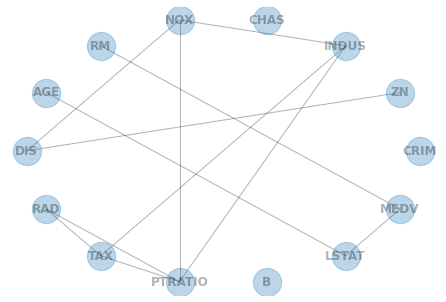

In [6]:
# Undirected edges（方向性なし）可視化
G = nx.Graph()
G.add_nodes_from(df.columns)  # ノード
G.add_edges_from(skel.edges())  # 辺
nx.draw_circular(
    G, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

In [7]:
# PDAG edges（部分的な方向性あり）可視化
PDAG_model = BayesianModel(pdag.edges())
nx.draw_circular(PDAG_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight='bold')
plt.show()

ValueError: Loops are not allowed. Adding the edge from (NOX->INDUS) forms a loop.

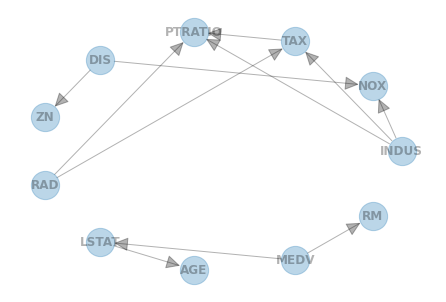

In [8]:
# DAG edges(方向性あり)可視化
DAG_model = BayesianModel(model.edges())
nx.draw_circular(
    DAG_model,
    with_labels=True,
    arrowsize=30,
    node_size=800,
    alpha=0.3,
    font_weight="bold",
)
plt.show()